# Data description & Problem statement: 
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. I build a classifier using machine learning which will help in identifying whether a given SMS is a Spam or not.


# Workflow:
- Load the training and test datasets
- Data cleaning (e.g. remove formats and punctuations)
- Basic data exploration
- Text vectorization, using "Bag of Words" technique
- Use "tf-idf transformation", and find the "N-grams" to improve the model performace
- Use a supervised classifier (e.g. Logistic Regression, Naive Bayes, etc.) for text classification: Use Grid-Serach along with Cross-Validation technique for finding the optimal hyper-parameters of best classifier
- Evaluate the performance of best classifier on the test data set, by calculating:
     - f1, Precision, Recall scores
     - Confusion matrix
     - ROC curve


Note: I repeat abovementioned process with and without Word Normalization (i.e. using lammatization/stemming) for the sake of comparison. For the word normalization I use "SpaCy" library.

In [1]:
import sklearn
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# we insatll and import spacy package for some advanced tokenizaion techniques:
import spacy

# we also install and import mglearn package (using !pip install mglearn) for some interesting visualization of results:
import mglearn

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 3EA9-93A4

 Directory of C:\Users\rhash\Documents\Datasets\NLP projects (sklearn & Spark)

12/29/2018  08:34 PM    <DIR>          .
12/29/2018  08:34 PM    <DIR>          ..
12/29/2018  08:33 PM    <DIR>          .ipynb_checkpoints
09/10/2018  10:29 AM    <DIR>          aclImdb
09/10/2018  10:57 AM    <DIR>          cache
08/02/2018  05:00 PM           100,912 Dataset_Challenge_Dataset_Agreement.pdf
12/29/2018  07:17 PM           150,838 IMDb review classification (Sentiment analysis with Scikit-learn).ipynb
12/29/2018  06:59 PM             9,544 IMDb topic modeling (with Latent Dirichlet Allocation in Scikit-Learn).ipynb
04/18/2011  01:53 PM             5,868 readme
12/29/2018  08:28 PM           199,675 SMS classification, Spam or Ham (with Linear Regression).ipynb
12/29/2018  08:34 PM            15,918 SMS classification, Spam or Ham (with Naive Bayes).ipynb
12/29/2018  07:26 PM            28,567 SMS topic modeling (with Latent Diric

# load and prepare the text data: 

In [3]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]

In [4]:
#labels = [1 if m.split('\t')[0]=='ham' else 0 for m in messages]
#sms = [m.split('\t')[1] for m in messages]

In [5]:
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=['labels', 'sms'])

In [6]:
messages.describe()

,labels,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
messages.groupby('labels').describe()

sms                                                               
       count unique                                                top freq
labels                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [8]:
messages['length']= messages['sms'].map(lambda x: len(x))

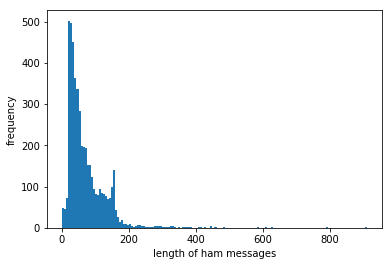

In [9]:
# histogram of length of ham messages:
plt.hist(messages[messages['labels']=='ham']['length'], bins=150)
plt.xlabel('length of ham messages')
plt.ylabel('frequency')
plt.show()

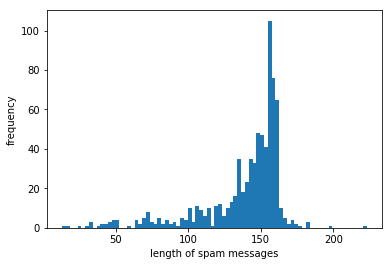

In [10]:
# histogram of length of spam messages:
plt.hist(messages[messages['labels']=='spam']['length'], bins=80)
plt.xlabel('length of spam messages')
plt.ylabel('frequency')
plt.show()

In [11]:
messages['labels'] = messages['labels'].map({'ham':1, 'spam':0})

In [12]:
from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test = train_test_split(messages['sms'], messages['labels'], test_size=0.2, random_state=42)

# Semantic analysis with tf-idf and N-grams with Naive Bayes model: 
    * Approach 1: without word normalization (i.e. lammatization or stemming)

In [13]:
# We find the best setting of n-gram range and logistic regression parameter using a grid search:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold


pipe = make_pipeline(TfidfVectorizer(min_df=10), 
                     MultinomialNB()) 

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams 
param_grid = {"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid1 = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kfold, scoring='f1') 
grid1.fit(text_train, y_train) 

G=pd.DataFrame(grid1.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.557033,0.015479,0.143581,0.011855,"(1, 2)","{'tfidfvectorizer__ngram_range': (1, 2)}",0.988850,0.986154,0.981623,0.985544,0.002982,1,0.987123,0.988842,0.989032,0.988332,0.000859
2,0.804910,0.120841,0.155928,0.019023,"(1, 3)","{'tfidfvectorizer__ngram_range': (1, 3)}",0.988850,0.986154,0.981623,0.985544,0.002982,1,0.986744,0.988462,0.989032,0.988079,0.000973
0,0.167369,0.024616,0.055198,0.006894,"(1, 1)","{'tfidfvectorizer__ngram_range': (1, 1)}",0.985063,0.983481,0.979748,0.982765,0.002228,3,0.984267,0.984863,0.986359,0.985163,0.000880


In [14]:
print("Best parameters:\n{}".format(grid1.best_params_), '\n')
print("Best cross-validation score: {:.2f}".format(grid1.best_score_)) 
print("Test score: {:.2f}".format(grid1.score(text_test, y_test)))

Best parameters:
{'tfidfvectorizer__ngram_range': (1, 2)} 

Best cross-validation score: 0.99
Test score: 0.99


In [15]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test, grid1.predict(text_test), target_names=['spam', 'ham'])
print(report)

             precision    recall  f1-score   support

       spam       1.00      0.91      0.95       149
        ham       0.99      1.00      0.99       966

avg / total       0.99      0.99      0.99      1115



Confusion matrix, without normalization
[[136  13]
 [  0 966]]
Normalized confusion matrix
[[0.91 0.09]
 [0.   1.  ]]


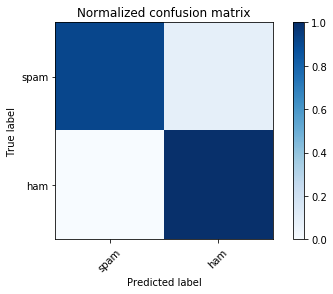

In [16]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["spam", "ham"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid1.predict(text_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

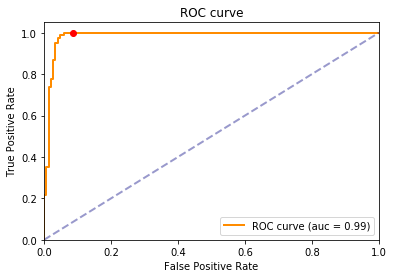

In [17]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid1.predict_proba(text_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid1.predict_proba(text_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

# Semantic analysis with tf-idf and N-grams using Naive Bayes model: 
    * Approach 2: with word normalization (i.e. using lammatization or stemming)

In [18]:
# run following script in the command line with admin privilage, to load the english package in spaCy:
# python -m spacy download en

In [20]:
# Technicality: we want to use the regexp-based tokenizer that is used by CountVectorizer 
# and only use the lemmatization from spacy. 
# We replace en_nlp.tokenizer (the spacy tokenizer) with the regexp-based tokenization:

from sklearn.feature_extraction.text import CountVectorizer
import re 

# regexp used in CountVectorizer 
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer 
en_nlp = spacy.load('en') 
old_tokenizer = en_nlp.tokenizer 

# replace the tokenizer with the preceding regexp 
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline (now using our own tokenizer) 
def custom_tokenizer(document):    
    doc_spacy = en_nlp(document)    
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer 
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer,
                             min_df=5, 
                             max_features=500,
                             ngram_range=(1, 2)).fit(text_train)

In [21]:
# transform text_train using CountVectorizer with lemmatization 
X_train_lemma = lemma_vect.transform(text_train) 
X_test_lemma = lemma_vect.transform(text_test[0:1000])

print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

X_train_lemma.shape: (4457, 500)


In [22]:
# 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(TfidfTransformer(), 
                    MultinomialNB(alpha=0.00001)) 

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores=cross_val_score(pipe, X_train_lemma, y_train, cv=kfold, scoring="f1_weighted")

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.98 0.98 0.96] 

Accuracy: 0.97 (+/- 0.01)


In [23]:
model_lemma=pipe.fit(X_train_lemma, y_train)

In [24]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report


report=classification_report(y_test[0:1000], model_lemma.predict(X_test_lemma), target_names=['spam', 'ham'])
print(report)

             precision    recall  f1-score   support

       spam       0.98      0.86      0.92       127
        ham       0.98      1.00      0.99       873

avg / total       0.98      0.98      0.98      1000



Confusion matrix, without normalization
[[109  18]
 [  2 871]]
Normalized confusion matrix
[[0.86 0.14]
 [0.   1.  ]]


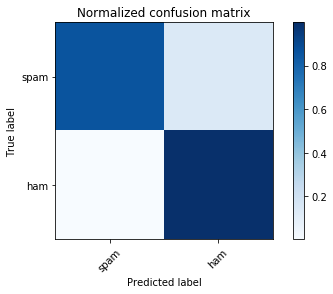

In [25]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["spam", "ham"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test[0:1000], model_lemma.predict(X_test_lemma))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

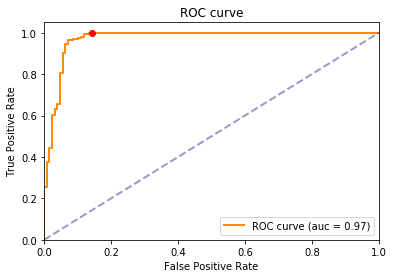

In [26]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[0:1000]), model_lemma.predict_proba(X_test_lemma)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test[0:1000]), model_lemma.predict_proba(X_test_lemma)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()